# Data Analysis with Python (Olist E-Commerce)

This notebook performs an end-to-end analysis of the Brazilian E-Commerce dataset using BigQuery and Python.

In [38]:
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns

client = bigquery.Client(project="brazilian-ecommerce-462514")
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


## 📊 Monthly Sales Trend


> 💡 **Insight:** Revenue trends reveal seasonal peaks and valleys, with consistent growth in specific months.

**Recommendations:**
- **Marketing:** Schedule campaigns around high-revenue months.
- **Finance:** Use revenue trends for cash flow forecasting.
- **Operations:** Plan inventory and staffing based on peak periods.


/home/davidliaoky/miniconda3/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


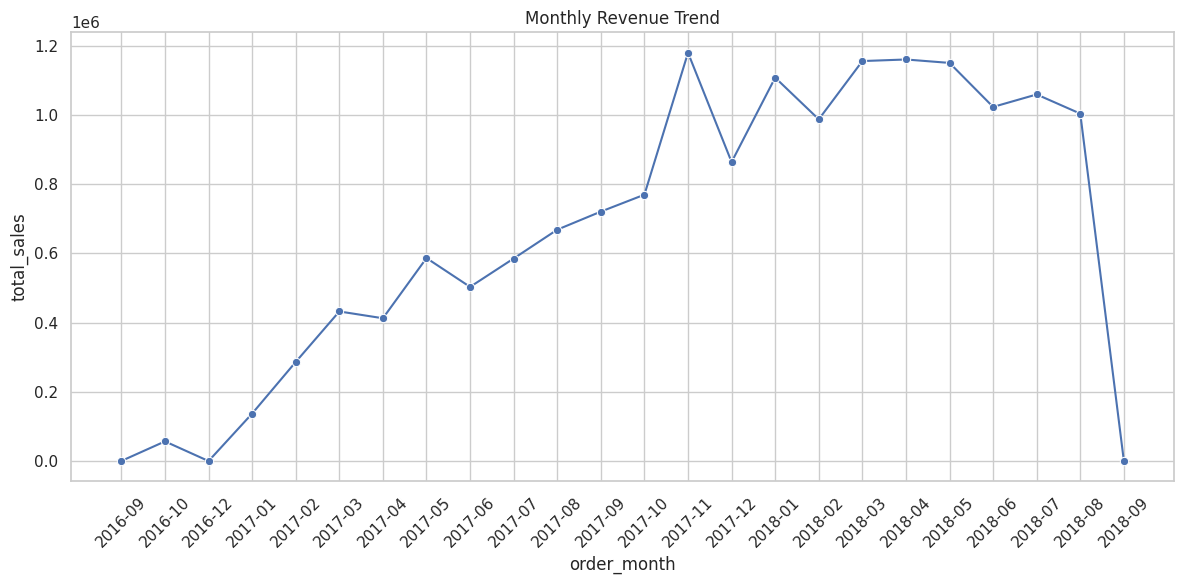

In [39]:
query = """
SELECT order_month, total_sales, num_orders
FROM `brazilian-ecommerce-462514.brazilian_ecommerce.fact_monthly_sales`
ORDER BY order_month
"""
monthly_sales = client.query(query).to_dataframe()
sns.lineplot(data=monthly_sales, x='order_month', y='total_sales', marker='o')
plt.title('Monthly Revenue Trend')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



> 💡 **Insight:** Revenue showed strong growth through 2017 and remained high in 2018, with a notable drop in Sept 2018 likely due to incomplete data.
> - **Marketing:** Schedule campaigns around Q4.
> - **Ops:** Ensure fulfillment can handle year-end demand.
> - **Finance:** Use post-2017 as a forecasting baseline.



> ⚠️ **Data Note:** No data for November 2016. This likely reflects early platform usage or data limitations.


## 🏆 Top 10 Selling Product Categories by Revenue


> 💡 **Insight:** A small number of product categories generate the majority of revenue.

**Recommendations:**
- **Marketing:** Promote best-selling categories in seasonal campaigns.
- **Inventory Management:** Prioritize stock for top performers to avoid stockouts.
- **Category Development:** Introduce adjacent products or bundles in popular categories.


/home/davidliaoky/miniconda3/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


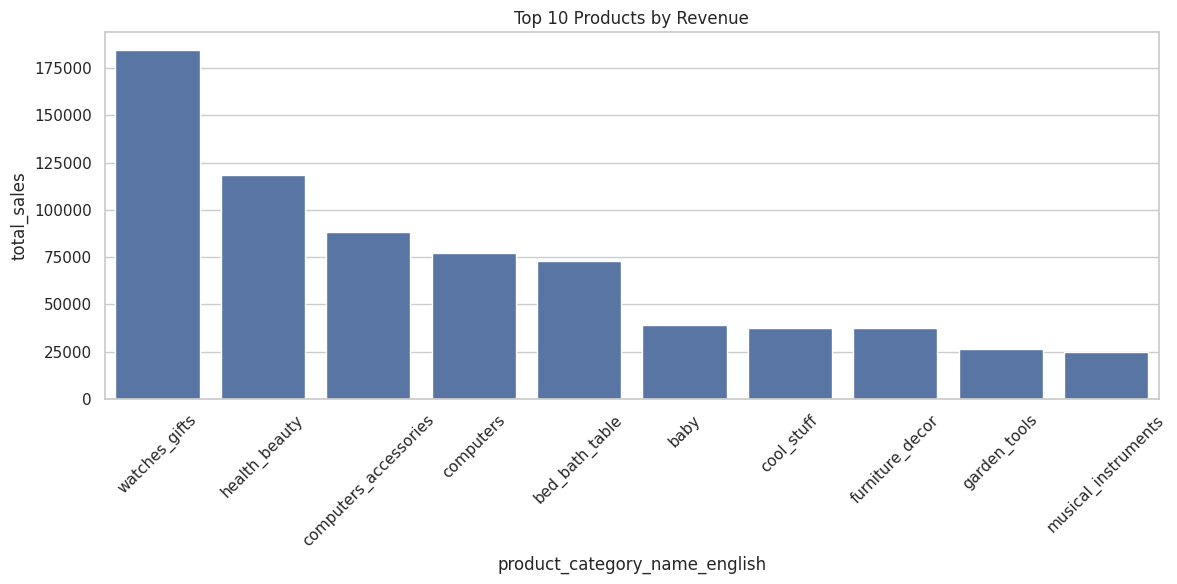

In [40]:
query = """
SELECT product_category_name_english, SUM(total_revenue) AS total_sales
FROM `brazilian-ecommerce-462514.brazilian_ecommerce.fact_product_sales_summary`
GROUP BY product_category_name_english
ORDER BY total_sales DESC
LIMIT 10
"""
top_products = client.query(query).to_dataframe()
sns.barplot(data=top_products, x='product_category_name_english', y='total_sales')
plt.title('Top 10 Products by Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



> 💡 **Insight:** Categories like watches, beauty, and electronics dominate.
> - Focus campaigns and restocking on high-performing categories.


## 👥 Customer Lifetime Value Distribution


> 💡 **Insight:** Most customers contribute low lifetime value, while a small elite group accounts for a large portion of revenue.

**Recommendations:**
- **CRM:** Segment high-value customers for loyalty and retention efforts.
- **Acquisition:** Target channels that historically yield high-LTV customers.
- **Support:** Allocate premium service levels to top-tier customers.


/home/davidliaoky/miniconda3/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


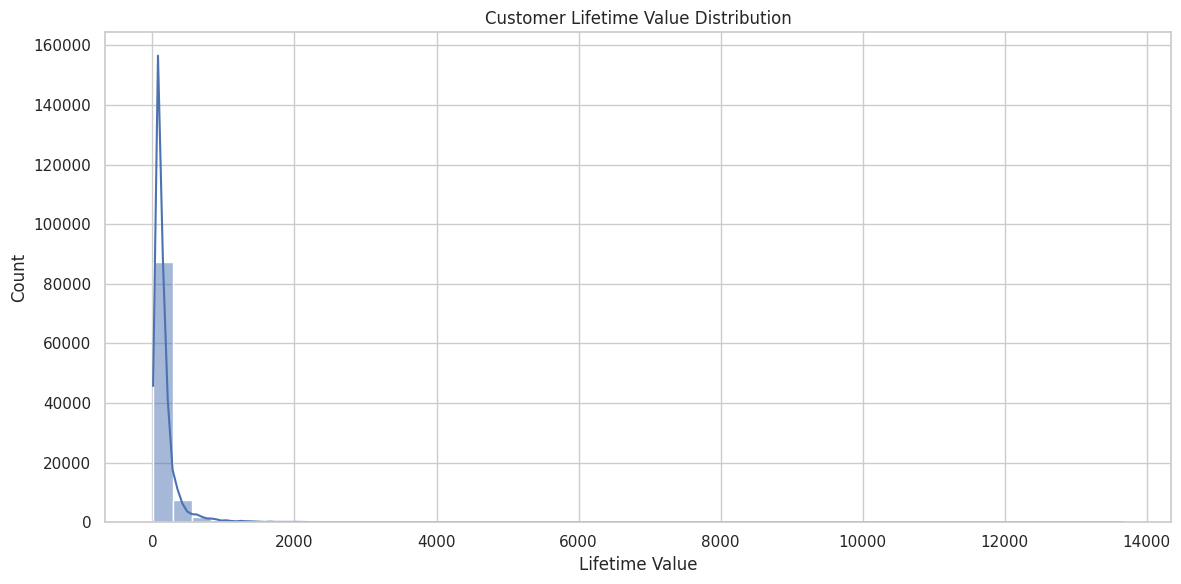

In [4]:
query = """
SELECT customer_id, lifetime_value
FROM `brazilian-ecommerce-462514.brazilian_ecommerce.fact_customer_lifetime`
"""
clv = client.query(query).to_dataframe()
sns.histplot(clv['lifetime_value'], bins=50, kde=True)
plt.title('Customer Lifetime Value Distribution')
plt.xlabel('Lifetime Value')
plt.tight_layout()
plt.show()



> 💡 **Insight:** Majority of customers spend less than R$500. A small group exceeds R$10,000.
> - Prioritize retention efforts on high-CLV customers.


## 🔁 Repeat Purchase Rate


> 💡 **Insight:** No recorded repeat purchases indicate one-time buyer behavior or data limitations.

**Recommendations:**
- **Analytics:** Validate uniqueness of customer_id and transaction linkage.
- **CRM:** Implement follow-up campaigns to convert first-time buyers.
- **Strategy:** Explore loyalty programs to encourage repeat buying behavior.


In [5]:
query = """
SELECT
  COUNT(*) AS total_customers,
  COUNTIF(order_count > 1) AS repeat_customers,
  COUNTIF(order_count > 1) / COUNT(*) AS repeat_purchase_rate
FROM (
  SELECT customer_id, COUNT(DISTINCT order_id) AS order_count
  FROM `brazilian-ecommerce-462514.brazilian_ecommerce.orders`
  GROUP BY customer_id
)
"""
repeat_rate = client.query(query).to_dataframe()
repeat_rate.T


/home/davidliaoky/miniconda3/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,0
total_customers,99441
repeat_customers,0
repeat_purchase_rate,0.0



> ⚠️ **Insight:** Repeat purchase rate is 0%, indicating either a one-time shopper model or anonymized customer IDs.


## 🌍 Sales by Customer State


> 💡 **Insight:** Revenue is concentrated in major states like São Paulo (SP), Rio de Janeiro (RJ), and Minas Gerais (MG).

**Recommendations:**
- **Logistics:** Optimize fulfillment and delivery in high-performing regions.
- **Marketing:** Deploy geo-targeted promotions where demand is highest.
- **Expansion Strategy:** Assess untapped regions with growth potential.


/home/davidliaoky/miniconda3/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


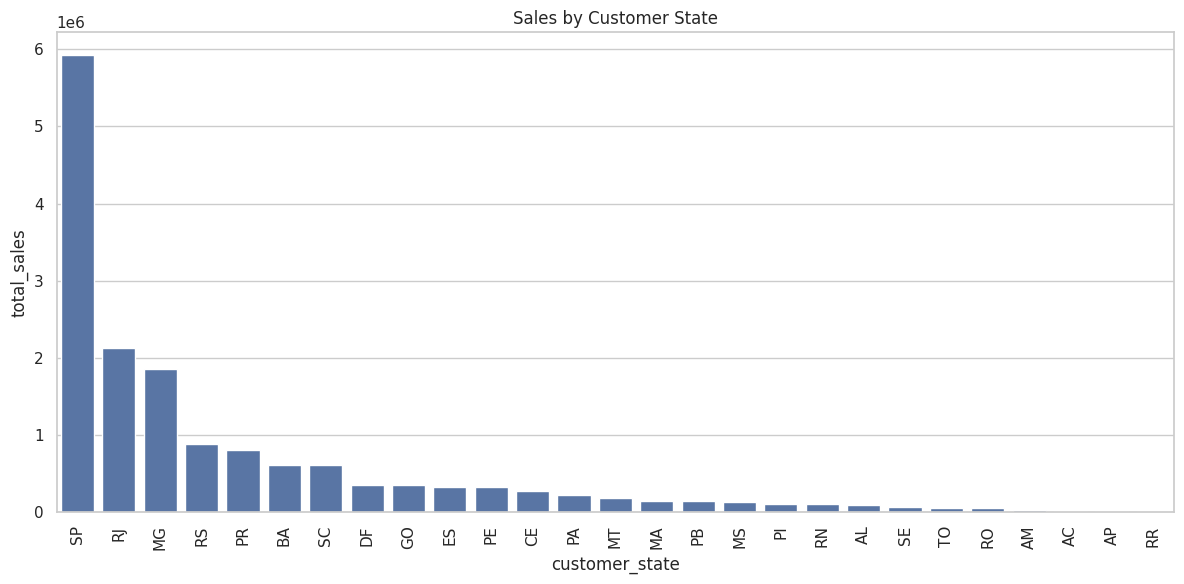

In [6]:
query = """
SELECT c.customer_state, ROUND(SUM(i.price + i.freight_value), 2) AS total_sales
FROM `brazilian-ecommerce-462514.brazilian_ecommerce.order_items` i
JOIN `brazilian-ecommerce-462514.brazilian_ecommerce.orders` o ON i.order_id = o.order_id
JOIN `brazilian-ecommerce-462514.brazilian_ecommerce.customers` c ON o.customer_id = c.customer_id
GROUP BY c.customer_state
ORDER BY total_sales DESC
"""
state_sales = client.query(query).to_dataframe()
sns.barplot(data=state_sales, x='customer_state', y='total_sales')
plt.title('Sales by Customer State')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



> 💡 **Insight:** São Paulo (SP) dominates total sales.
> - Localize logistics and marketing efforts for top regions.


## ⭐ Average Review Score by Product Category


> 💡 **Insight:** Categories like books and music consistently earn higher customer satisfaction scores.

**Recommendations:**
- **Product:** Improve quality or supplier reliability for low-rated categories.
- **Support:** Investigate and respond to recurring issues flagged in reviews.
- **Marketing:** Leverage top-rated products in brand messaging and testimonials.


/home/davidliaoky/miniconda3/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


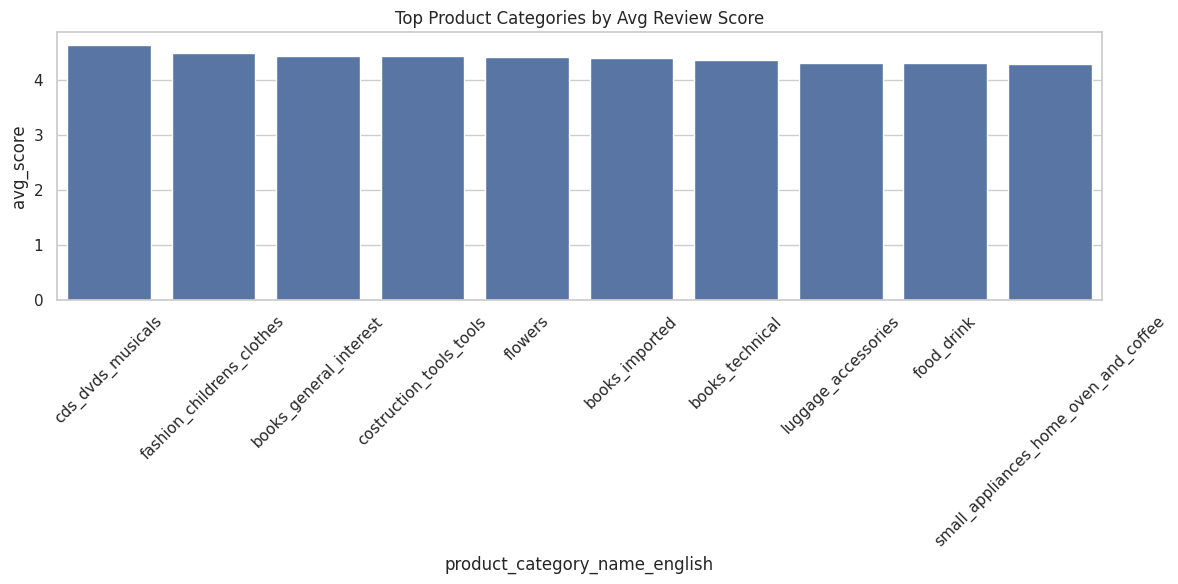

In [7]:
query = """
SELECT
  t.product_category_name_english,
  ROUND(AVG(CAST(r.review_score AS INT64)), 2) AS avg_score
FROM `brazilian-ecommerce-462514.brazilian_ecommerce.order_reviews` r
JOIN `brazilian-ecommerce-462514.brazilian_ecommerce.orders` o ON r.order_id = o.order_id
JOIN `brazilian-ecommerce-462514.brazilian_ecommerce.order_items` i ON o.order_id = i.order_id
JOIN `brazilian-ecommerce-462514.brazilian_ecommerce.products` p ON i.product_id = p.product_id
JOIN `brazilian-ecommerce-462514.brazilian_ecommerce.product_category_name_translation` t
  ON p.product_category_name = t.product_category_name
GROUP BY t.product_category_name_english
ORDER BY avg_score DESC
"""
review_scores = client.query(query).to_dataframe()
sns.barplot(data=review_scores.head(10), x='product_category_name_english', y='avg_score')
plt.title('Top Product Categories by Avg Review Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



> 💡 **Insight:** Some categories like books and music have high ratings. Use this to promote top performers and review low-scoring areas.


## 🕐 Average Delivery Delay (in Days)


> 💡 **Insight:** Delivery speed is a key part of customer experience and varies across orders.

**Recommendations:**
- **Logistics:** Identify bottlenecks and optimize delivery routes or partners.
- **CX:** Communicate realistic delivery timelines during checkout.
- **Ops:** Evaluate warehouse location strategy and service-level agreements.


In [8]:
query = """
SELECT
  ROUND(AVG(DATE_DIFF(order_delivered_customer_date, order_approved_at, DAY)), 2) AS avg_delivery_days
FROM `brazilian-ecommerce-462514.brazilian_ecommerce.orders`
WHERE order_delivered_customer_date IS NOT NULL
"""
delivery = client.query(query).to_dataframe()
delivery


/home/davidliaoky/miniconda3/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,avg_delivery_days
0,11.98



> 💡 **Insight:** Use average delivery time to optimize fulfillment and set accurate delivery expectations.
